# Transfer Learning

Pytorch Tutorial의 예제를 통해 Transfer learning으로 개미와 벌을 분류하는 모델을 만들어보자! \[[예제 링크](https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html)\]


***Tutorial에서는 1(fine-tuning)의 성능이 2(feature extractor)의 성능보다 안좋게 나온 이유***

Tutorial에서는 1의 방법을 fine-tuning이라고 소개하고 있는데 아닌거 같음

원래는 2의 방법으로 fully connected layer를 먼저 학습하고 바로위의 convolution layer들 몇개랑 같이 learning rate줄여서 학습해야함

그렇게해야 학습된 모델의 feature map들을 많이 변형하지 않고 조금씩 custom data에 fine-tuning할 수 있고 좋은 성능을 낼 수 있음

## 1. Pretrained model 전체를 바로 학습시키기

In [1]:
import os
import copy
import time

import torch
import torchvision

from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

# Image data augmentation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Dataset Load
data_dir = "../datasets/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ["train", "val"]}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                              shuffle=True, num_workers=4)
                for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

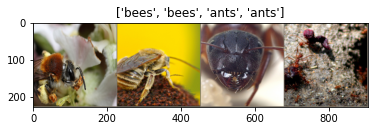

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Show image data augmentation results
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get mini-batch
inputs, classes = next(iter(dataloaders['train']))

# Make grid image
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.shape[0]
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc : {:.4f}".format(best_acc))
    
    # return best model
    model.load_state_dict(best_model_wts)
    return model

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [5]:
# 마지막 fully connected layer의 output수를 1000->2로 수정
model_trained = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_trained.fc.in_features
model_trained.fc = nn.Linear(num_ftrs, 2)
model_trained = model_trained.to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_trained = optim.SGD(model_trained.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer_trained, step_size=7, gamma=0.1)

model_trained = train_model(model_trained, criterion, optimizer_trained, scheduler,
                            num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7370 Acc: 0.6639
val Loss: 0.2813 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6074 Acc: 0.7459
val Loss: 0.3061 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4920 Acc: 0.7746
val Loss: 0.2418 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5735 Acc: 0.7623
val Loss: 0.3028 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.6177 Acc: 0.7377
val Loss: 0.3146 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5716 Acc: 0.8033
val Loss: 0.3529 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.2878 Acc: 0.8893
val Loss: 0.2602 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3624 Acc: 0.8689
val Loss: 0.2278 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3528 Acc: 0.8525
val Loss: 0.2175 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4038 Acc: 0.8197
val Loss: 0.2100 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4241 Acc: 0.8361
val Loss: 0.2080 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2251 Acc: 0.8893
val Loss: 0.2194 Acc: 0.9216

Ep

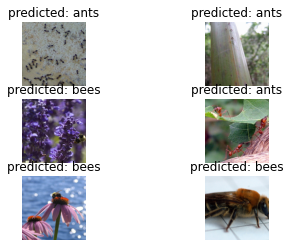

In [7]:
visualize_model(model_trained)

## 2. Feature Extractor로만 사용하기

`requires_grad = False`로 layer를 freezing한다.

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6804 Acc: 0.6598
val Loss: 0.2792 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5193 Acc: 0.7869
val Loss: 0.1952 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5259 Acc: 0.7705
val Loss: 0.1983 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4936 Acc: 0.7910
val Loss: 0.1998 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4977 Acc: 0.8074
val Loss: 0.3340 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3839 Acc: 0.8115
val Loss: 0.2081 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4152 Acc: 0.8238
val Loss: 0.3996 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.3518 Acc: 0.8689
val Loss: 0.2137 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3692 Acc: 0.8238
val Loss: 0.2102 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4430 Acc: 0.8402
val Loss: 0.2160 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3965 Acc: 0.8320
val Loss: 0.2277 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3177 Acc: 0.8361
val Loss: 0.2059 Acc: 0.9412

Ep

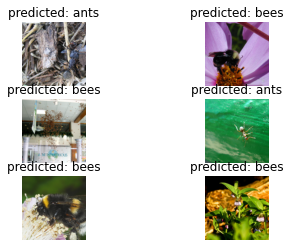

In [10]:
visualize_model(model_conv)